# Cytokine Signaling Dynamics — 10-Cytokine Subset Experiment

Runs the full AB-MIL pipeline on a curated 10-cytokine subset + PBS control.

## Rationale for cytokine selection

The subset is designed to provide a **clear expected contrast** between easy-to-learn
(high learnability AUC) and hard-to-learn (low AUC) cytokines, grounded in both
the literature and preliminary full-experiment rankings reported in the source paper.

The hard group includes IL-12 as a **cascade positive control**: the paper (Fig. 4i)
explicitly shows that IL-12 drives its PBMC effects indirectly via IFN-γ induction,
making it a clean test of whether the model recovers secondary-cascade cytokines as
harder to learn than direct activators.

### Expected easy group — direct, PBMC-specific, strong 24-h transcriptional response
| Cytokine | Key mechanism | Evidence |
|---|---|---|
| IL-4 | Strong Th2/B cell axis via STAT6 | Ranked #1 in full-experiment preliminary run |
| M-CSF | Direct monocyte survival/activation via CSF1R | Ranked #3 in preliminary run |
| IL-10 | Strong monocyte/B cell response via STAT3 | Ranked #4 in preliminary run |
| TNF-alpha | Canonical early NF-κB in monocytes/T cells | Well-established rapid inflammatory activator |
| IL-2 | Direct T/NK activation via γc receptor | Ranked #10 in preliminary run |

### Expected hard group — indirect, non-PBMC targets, or cascade-dependent
| Cytokine | Key mechanism | Why hard |
|---|---|---|
| IL-22 | Epithelial STAT3 via IL-22R1 | Targets epithelium, not PBMCs — minimal direct PBMC signal |
| VEGF | Endothelial growth via VEGFR | Endothelial target; PBMCs lack significant VEGFR expression |
| IL-12 | IFN-γ induction in NK/T cells | **Cascade control**: effect is indirect (Fig. 4i explicitly shows secondary IFN-γ cascade) |
| OSM | Oncostatin M via gp130 | Non-PBMC primary targets; ranked near bottom in preliminary run |
| HGF | Hepatocyte growth via c-Met | Hepatocyte/stromal target; minimal direct PBMC transcriptional response |

**Pre-registered predictions:**
- IL-4, M-CSF, IL-10 should rank in the top 3 by learnability AUC.
- IL-22, VEGF, HGF should rank in the bottom 3.
- IL-12 should rank low despite being immunostimulatory (indirect cascade effect, not direct PBMC activation).

Connect to the cluster kernel before running.
All paths in `configs/default.yaml` point to cluster storage.

In [1]:
import json
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr
from torch.utils.data import DataLoader

from cytokine_mil.data.label_encoder import CytokineLabel
from cytokine_mil.data.dataset import PseudoTubeDataset, CellDataset
from cytokine_mil.models.instance_encoder import InstanceEncoder
from cytokine_mil.models.attention import AttentionModule
from cytokine_mil.models.bag_classifier import BagClassifier
from cytokine_mil.models.cytokine_abmil import CytokineABMIL
from cytokine_mil.training.train_encoder import train_encoder
from cytokine_mil.training.train_mil import train_mil
from cytokine_mil.experiment_setup import (
    build_stage1_manifest,
    filter_manifest,
    split_manifest_by_donor,
    build_encoder,
    build_mil_model,
)
from cytokine_mil.analysis.dynamics import (
    aggregate_to_donor_level,
    rank_cytokines_by_learnability,
    compute_cytokine_entropy_summary,
    compute_confusion_entropy_summary,
    build_cell_type_confidence_matrix,
)
from cytokine_mil.analysis.validation import (
    check_seed_stability,
    check_functional_groupings,
)

In [2]:
# --- Config ---
with open("cytokines/cytokines-mil/configs/default.yaml") as f:
    cfg = yaml.safe_load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = cfg["dynamics"]["random_seeds"][0]
print(f"Device: {DEVICE}")
print(f"Seed: {SEED}")

Device: cuda
Seed: 42


## 1. Data

In [3]:
MANIFEST_PATH = cfg["data"]["manifest_path"]

with open(MANIFEST_PATH) as f:
    manifest = json.load(f)

# Load HVG list (saved by preprocess_tubes.ipynb)
HVG_PATH = str(Path(MANIFEST_PATH).parent / "hvg_list.json")
with open(HVG_PATH) as f:
    gene_names = json.load(f)

print(f"Full manifest entries: {len(manifest)}")
print(f"HVGs: {len(gene_names)}")

Full manifest entries: 10920
HVGs: 4000


In [4]:
# --- Cytokine subset selection ---
# Verify that these names exactly match the cytokine field in your manifest.json.
# Run the cell below to cross-check before proceeding.
# NOTE: TNF-alpha naming may vary (e.g. "TNF-alpha", "TNFa", "TNF") — adjust if flagged.

# 5 cytokines with direct, PBMC-specific, strong effects — expected easy to learn
EASY_CYTOKINES = [
    "IL-4",        # #1 in preliminary run — strong Th2/B cell axis via STAT6
    "M-CSF",       # #3 in preliminary run — direct monocyte survival/activation via CSF1R
    "IL-10",       # #4 in preliminary run — strong monocyte/B cell STAT3 response
    "TNF-alpha",   # canonical NF-κB activator — rapid direct effect on monocytes/T cells
    "IL-2",        # #10 in preliminary run — direct T/NK activation via γc receptor
]

# 5 cytokines with indirect, non-PBMC-primary, or cascade-dependent effects — expected hard to learn
HARD_CYTOKINES = [
    "IL-22",   # targets epithelium via IL-22R1 — minimal direct PBMC transcriptional signal
    "VEGF",    # endothelial target via VEGFR — PBMCs lack significant VEGFR expression
    "IL-12",   # cascade control: drives IFN-γ in NK/T cells indirectly (Fig. 4i in source paper)
    "OSM",     # Oncostatin M — non-PBMC primary targets, near bottom in preliminary run
    "HGF",     # hepatocyte/stromal target via c-Met — weak direct PBMC response
]

SUBSET_CYTOKINES = EASY_CYTOKINES + HARD_CYTOKINES

# Verify names against manifest before continuing
manifest_cytokines = {e["cytokine"] for e in manifest}
missing = [c for c in SUBSET_CYTOKINES if c not in manifest_cytokines]
if missing:
    print(f"WARNING — cytokines not found in manifest (check naming): {missing}")
    print(f"Available names (sample): {sorted(manifest_cytokines)[:20]}")
else:
    print("All selected cytokines found in manifest.")
print(f"Selected {len(SUBSET_CYTOKINES)} cytokines: {SUBSET_CYTOKINES}")

All selected cytokines found in manifest.
Selected 10 cytokines: ['IL-4', 'M-CSF', 'IL-10', 'TNF-alpha', 'IL-2', 'IL-22', 'VEGF', 'IL-12', 'OSM', 'HGF']


In [5]:
# Filter manifest to the 10-cytokine subset + PBS
subset_manifest = filter_manifest(manifest, cytokines=SUBSET_CYTOKINES, include_pbs=True)

# Count classes: 10 cytokines + PBS = 11
subset_cytokine_names = {e["cytokine"] for e in subset_manifest}
print(f"Subset manifest entries: {len(subset_manifest)}")
print(f"Unique classes: {sorted(subset_cytokine_names)}")
print(f"n_classes = {len(subset_cytokine_names)}  (10 cytokines + PBS)")

Subset manifest entries: 1320
Unique classes: ['HGF', 'IL-10', 'IL-12', 'IL-2', 'IL-22', 'IL-4', 'M-CSF', 'OSM', 'PBS', 'TNF-alpha', 'VEGF']
n_classes = 11  (10 cytokines + PBS)


In [6]:
# Label encoder — fitted on subset manifest for consistent index mapping
LABEL_ENCODER_PATH = str(Path(MANIFEST_PATH).parent / "label_encoder_subset.json")
label_encoder = CytokineLabel().fit(subset_manifest)
label_encoder.save(LABEL_ENCODER_PATH)
print(f"Classes: {label_encoder.n_classes()} (PBS at index {label_encoder.encode('PBS')})")

Classes: 91 (PBS at index 90)


In [9]:
# --- Donor-level train/val split (see CLAUDE.md Section 16) ---
# D2 and D3 are the most biologically distinct donors in the cohort.
# They are held out for generalization testing and never used in optimizer steps.
# VAL_DONORS = cfg["data"]["val_donors"]  # ["Donor2", "Donor3"]
VAL_DONORS = ["Donor2", "Donor3"]
train_manifest, val_manifest = split_manifest_by_donor(subset_manifest, val_donors=VAL_DONORS)
print(f"Train donors: {sorted({e['donor'] for e in train_manifest})}  ({len(train_manifest)} tubes)")
print(f"Val donors:   {sorted({e['donor'] for e in val_manifest})}  ({len(val_manifest)} tubes)")

# Save manifests for dataset construction
SUBSET_MANIFEST_PATH = str(Path(MANIFEST_PATH).parent / "manifest_subset.json")
TRAIN_MANIFEST_PATH  = str(Path(MANIFEST_PATH).parent / "manifest_subset_train.json")
VAL_MANIFEST_PATH    = str(Path(MANIFEST_PATH).parent / "manifest_subset_val.json")
with open(SUBSET_MANIFEST_PATH, "w") as f:
    json.dump(subset_manifest, f)
with open(TRAIN_MANIFEST_PATH, "w") as f:
    json.dump(train_manifest, f)
with open(VAL_MANIFEST_PATH, "w") as f:
    json.dump(val_manifest, f)

# Pseudo-tube datasets (Stage 2/3) — train and val separate
# preload=True: loads all tubes as sparse matrices at init — eliminates disk I/O during training.
train_tube_dataset = PseudoTubeDataset(TRAIN_MANIFEST_PATH, label_encoder, gene_names=gene_names, preload=True)
val_tube_dataset   = PseudoTubeDataset(VAL_MANIFEST_PATH,   label_encoder, gene_names=gene_names, preload=True)
print(f"Train tubes: {len(train_tube_dataset)}")
print(f"Val tubes:   {len(val_tube_dataset)}")

# --- Stage 1 manifest: one tube per cytokine, rotating donors (train donors only) ---
STAGE1_MANIFEST_PATH = str(Path(MANIFEST_PATH).parent / "manifest_stage1_subset.json")
_stage1_manifest = build_stage1_manifest(train_manifest, save_path=STAGE1_MANIFEST_PATH)

# preload=True: loads all cells at init → in-memory shuffling, no disk I/O per batch
cell_dataset = CellDataset(STAGE1_MANIFEST_PATH, gene_names=gene_names, preload=True)
print(f"Cells: {len(cell_dataset)}")
print(f"Cell types: {cell_dataset.n_cell_types()}")
print(f"NaN in X: {np.isnan(cell_dataset._X).any()}")
print(f"Inf in X: {np.isinf(cell_dataset._X).any()}")
print(f"X range: [{cell_dataset._X.min():.3f}, {cell_dataset._X.max():.3f}]")

cell_loader = DataLoader(cell_dataset, batch_size=256, shuffle=True, num_workers=0)

Train donors: ['Donor1', 'Donor10', 'Donor11', 'Donor12', 'Donor4', 'Donor5', 'Donor6', 'Donor7', 'Donor8', 'Donor9']  (1100 tubes)
Val donors:   ['Donor2', 'Donor3']  (220 tubes)


Preloading tubes: 100%|██████████████████████| 220/220 [00:33<00:00,  6.65it/s]


Train tubes: 1100
Val tubes:   220
Cells: 4873
Cell types: 18
NaN in X: False
Inf in X: False
X range: [0.000, 7.752]


## 2. Stage 1 — Encoder Pre-training

In [10]:
encoder = build_encoder(
    n_input_genes=len(gene_names),
    n_cell_types=cell_dataset.n_cell_types(),
    embed_dim=cfg["model"]["embedding_dim"],
)

encoder = train_encoder(
    encoder,
    cell_loader,
#    n_epochs=cfg["training"]["stage1_epochs"],
    n_epochs=10,
    lr=cfg["training"]["lr"],
    momentum=cfg["training"]["momentum"],
    device=DEVICE,
    verbose=True,
)

torch.save(encoder.state_dict(), "encoder_stage1_subset.pt")
print("Encoder saved.")

[Stage 1] Epoch   1/10 | loss=2.4682 | acc=0.3304


[Stage 1] Epoch   2/10 | loss=0.5376 | acc=0.8085


[Stage 1] Epoch   3/10 | loss=0.3312 | acc=0.8806


[Stage 1] Epoch   4/10 | loss=0.2589 | acc=0.9013


[Stage 1] Epoch   5/10 | loss=0.1791 | acc=0.9393


[Stage 1] Epoch   6/10 | loss=0.1285 | acc=0.9610


[Stage 1] Epoch   7/10 | loss=0.0962 | acc=0.9723


[Stage 1] Epoch   8/10 | loss=0.0560 | acc=0.9879


[Stage 1] Epoch   9/10 | loss=0.0335 | acc=0.9953


[Stage 1] Epoch  10/10 | loss=0.0183 | acc=0.9990
Encoder saved.


## 3. Stage 2 — MIL Training (encoder frozen)

In [11]:
# n_classes derived from the label encoder — 11 for the 10-cytokine subset + PBS
mil_model = build_mil_model(
    encoder,
    embed_dim=cfg["model"]["embedding_dim"],
    attention_hidden_dim=cfg["model"]["attention_hidden_dim"],
    n_classes=label_encoder.n_classes(),
    encoder_frozen=True,
)

dynamics_stage2 = train_mil(
    mil_model,
    train_tube_dataset,                              # train donors only
    n_epochs=20,
    #n_epochs=cfg["training"]["stage2_epochs"],
    lr=cfg["training"]["lr"],
    momentum=cfg["training"]["momentum"],
    lr_scheduler=cfg["training"]["lr_scheduler"],
    lr_warmup_epochs=cfg["training"]["lr_warmup_epochs"],
    log_every_n_epochs=cfg["dynamics"]["log_every_n_epochs"],
    device=DEVICE,
    seed=SEED,
    verbose=True,
    val_dataset=val_tube_dataset,                    # observer only — no gradient updates
)

torch.save(mil_model.state_dict(), "mil_stage2_subset.pt")
print("Stage 2 model saved.")
print(f"Train records: {len(dynamics_stage2['records'])}")
print(f"Val records:   {len(dynamics_stage2['val_records'])}")

[Stage 2/3] Epoch   1/20 | loss=2.3624


[Stage 2/3] Epoch   2/20 | loss=1.8294


[Stage 2/3] Epoch   3/20 | loss=1.7063


[Stage 2/3] Epoch   4/20 | loss=1.6000


[Stage 2/3] Epoch   5/20 | loss=1.5096


[Stage 2/3] Epoch   6/20 | loss=1.4487


[Stage 2/3] Epoch   7/20 | loss=1.3027


[Stage 2/3] Epoch   8/20 | loss=1.1879


[Stage 2/3] Epoch   9/20 | loss=1.0555


[Stage 2/3] Epoch  10/20 | loss=0.9405


[Stage 2/3] Epoch  11/20 | loss=0.8559


[Stage 2/3] Epoch  12/20 | loss=0.6831


[Stage 2/3] Epoch  13/20 | loss=0.6047


[Stage 2/3] Epoch  14/20 | loss=0.4240


[Stage 2/3] Epoch  15/20 | loss=0.4337


[Stage 2/3] Epoch  16/20 | loss=0.4526


[Stage 2/3] Epoch  17/20 | loss=0.3365


[Stage 2/3] Epoch  18/20 | loss=0.3402


[Stage 2/3] Epoch  19/20 | loss=0.3275


[Stage 2/3] Epoch  20/20 | loss=0.2099
Stage 2 model saved.
Train records: 1100
Val records:   220


## 4. Stage 3 — Joint Fine-tuning (optional)

In [12]:
mil_model.unfreeze_encoder()

dynamics_stage3 = train_mil(
    mil_model,
    train_tube_dataset,                              # train donors only
    n_epochs=20,
    # n_epochs=cfg["training"]["stage3_epochs"],
    lr=cfg["training"]["lr"] * 0.1,                  # lower LR for fine-tuning
    momentum=cfg["training"]["momentum"],
    log_every_n_epochs=cfg["dynamics"]["log_every_n_epochs"],
    device=DEVICE,
    seed=SEED,
    verbose=True,
    val_dataset=val_tube_dataset,                    # observer only — no gradient updates
)

torch.save(mil_model.state_dict(), "mil_stage3_subset.pt")
print("Stage 3 model saved.")

[Stage 2/3] Epoch   1/20 | loss=10.3010


[Stage 2/3] Epoch   2/20 | loss=0.9544


[Stage 2/3] Epoch   3/20 | loss=0.5858


[Stage 2/3] Epoch   4/20 | loss=0.2174


[Stage 2/3] Epoch   5/20 | loss=0.2645


[Stage 2/3] Epoch   6/20 | loss=0.1369


[Stage 2/3] Epoch   7/20 | loss=0.1578


[Stage 2/3] Epoch   8/20 | loss=0.1565


[Stage 2/3] Epoch   9/20 | loss=0.0970


[Stage 2/3] Epoch  10/20 | loss=0.0053


[Stage 2/3] Epoch  11/20 | loss=0.0012


[Stage 2/3] Epoch  12/20 | loss=0.0006


[Stage 2/3] Epoch  13/20 | loss=0.0005


[Stage 2/3] Epoch  14/20 | loss=0.0004


[Stage 2/3] Epoch  15/20 | loss=0.0004


[Stage 2/3] Epoch  16/20 | loss=0.0003


[Stage 2/3] Epoch  17/20 | loss=0.0003


[Stage 2/3] Epoch  18/20 | loss=0.0003


[Stage 2/3] Epoch  19/20 | loss=0.0003


[Stage 2/3] Epoch  20/20 | loss=0.0003
Stage 3 model saved.


## 5. Dynamics Analysis

In [13]:
# Use Stage 2 dynamics for primary analysis (encoder frozen = cleaner dynamics)
donor_traj     = aggregate_to_donor_level(dynamics_stage2["records"])
val_donor_traj = aggregate_to_donor_level(dynamics_stage2["val_records"])

# Learnability ranking — train donors
learnability_result = rank_cytokines_by_learnability(donor_traj, exclude=["PBS"])
ranking = learnability_result["ranking"]

# Learnability ranking — val donors (D2, D3)
val_learnability_result = rank_cytokines_by_learnability(val_donor_traj, exclude=["PBS"])
val_ranking = val_learnability_result["ranking"]
val_auc_map  = {cyt: auc for cyt, auc in val_ranking}

print("Cytokine learnability ranking — Stage 2")
print(f"Metric: {learnability_result['metric_description']}")
print()
print(f"{'Rank':>4}  {'Cytokine':<20}  {'Train AUC':>10}  {'Val AUC':>8}  Group")
print("-" * 62)
for i, (cyt, auc) in enumerate(ranking, 1):
    group = "EASY" if cyt in EASY_CYTOKINES else "HARD"
    val_auc = val_auc_map.get(cyt, float("nan"))
    print(f"  {i:2d}.  {cyt:<20}  {auc:>10.3f}  {val_auc:>8.3f}  {group}")

# Evaluate pre-registered predictions (train)
top5 = [r[0] for r in ranking[:5]]
bot5 = [r[0] for r in ranking[-5:]]
easy_in_top5 = sum(c in EASY_CYTOKINES for c in top5)
hard_in_bot5 = sum(c in HARD_CYTOKINES for c in bot5)
il12_rank = next((i + 1 for i, (c, _) in enumerate(ranking) if c == "IL-12"), None)
print()
print("Pre-registered prediction check (train donors):")
print(f"  Easy cytokines in top-5: {easy_in_top5}/5  {top5}")
print(f"  Hard cytokines in bot-5: {hard_in_bot5}/5  {bot5}")
if il12_rank is not None:
    print(f"  IL-12 rank: {il12_rank}/{len(ranking)}  (expected low — indirect cascade via IFN-γ)")

# Train/val rank correlation
train_order = [c for c, _ in ranking]
val_order   = [c for c, _ in val_ranking]
if set(train_order) == set(val_order):
    val_ranks_aligned = [val_order.index(c) for c in train_order]
    rho, pval = spearmanr(range(len(train_order)), val_ranks_aligned)
    print()
    print(f"Train vs val rank correlation: Spearman rho = {rho:.3f}  (p={pval:.3f})")
    print("  rho > 0.7 → ranking generalizes to held-out donors.")

Cytokine learnability ranking — Stage 2
Metric: AUC of mean p_correct_trajectory across pseudo-tubes, aggregated to donor level (median across pseudo-tubes per donor, then mean across donors)

Rank  Cytokine               Train AUC   Val AUC  Group
--------------------------------------------------------------
   1.  IL-4                      18.091    10.568  EASY
   2.  IL-2                      15.719    16.113  EASY
   3.  IL-10                     13.351     3.505  EASY
   4.  IL-12                     10.752     6.005  HARD
   5.  TNF-alpha                 10.209     4.615  EASY
   6.  HGF                        9.009     1.181  HARD
   7.  IL-22                      8.916     0.780  HARD
   8.  M-CSF                      8.751     4.012  EASY
   9.  OSM                        8.201     1.939  HARD
  10.  VEGF                       7.902     2.615  HARD

Pre-registered prediction check (train donors):
  Easy cytokines in top-5: 4/5  ['IL-4', 'IL-2', 'IL-10', 'IL-12', 'TNF-alpha']

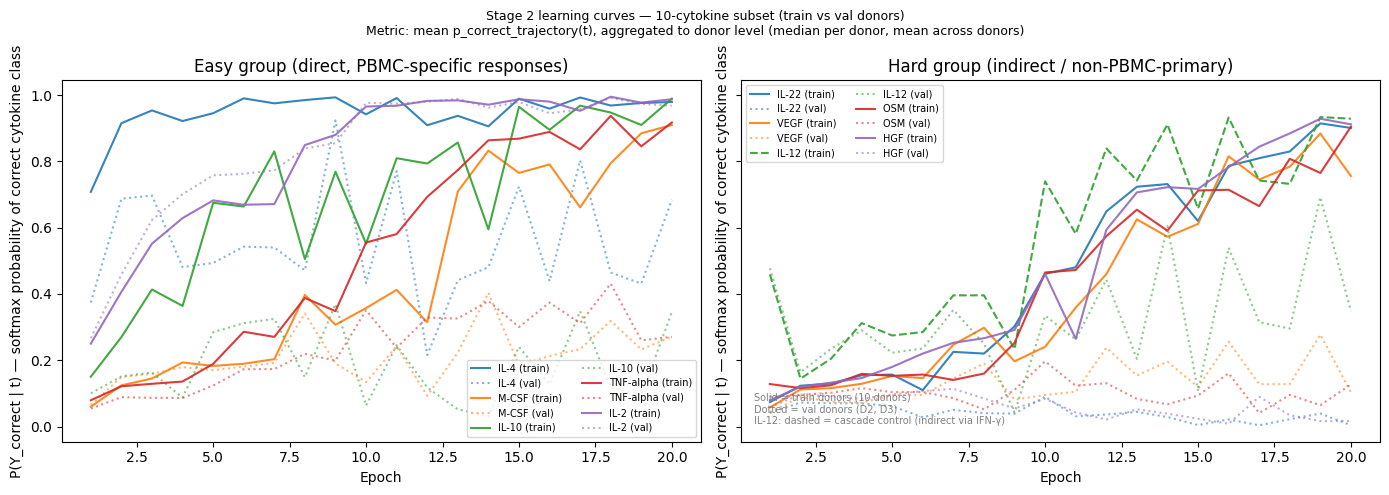

In [14]:
# Plot learning curves — train (solid) and val (dotted) in the same color per cytokine.
# A persistent train > val gap indicates the model is exploiting donor-specific expression.
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
epochs = dynamics_stage2["logged_epochs"]
colors = plt.cm.tab10.colors

for ax, group, group_label in zip(
    axes,
    [EASY_CYTOKINES, HARD_CYTOKINES],
    ["Easy group (direct, PBMC-specific responses)", "Hard group (indirect / non-PBMC-primary)"],
):
    for ci, cyt in enumerate(group):
        color = colors[ci % len(colors)]
        ls_mod = "--" if cyt == "IL-12" else "-"
        if cyt in donor_traj:
            train_mean = np.mean(list(donor_traj[cyt].values()), axis=0)
            ax.plot(epochs, train_mean, color=color, linestyle=ls_mod,
                    alpha=0.9, label=f"{cyt} (train)")
        if cyt in val_donor_traj:
            val_mean = np.mean(list(val_donor_traj[cyt].values()), axis=0)
            ax.plot(epochs, val_mean, color=color, linestyle=":",
                    alpha=0.55, label=f"{cyt} (val)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("P(Y_correct | t) — softmax probability of correct cytokine class")
    ax.set_title(group_label)
    ax.legend(fontsize=7, ncol=2)

axes[1].annotate(
    "Solid = train donors (10 donors)\nDotted = val donors (D2, D3)\nIL-12: dashed = cascade control (indirect via IFN-γ)",
    xy=(0.02, 0.05), xycoords="axes fraction", fontsize=7, color="gray",
)

plt.suptitle(
    "Stage 2 learning curves — 10-cytokine subset (train vs val donors)\n"
    "Metric: mean p_correct_trajectory(t), aggregated to donor level "
    "(median per donor, mean across donors)",
    fontsize=9,
)
plt.tight_layout()
plt.savefig("learning_curves_subset_trainval.png", dpi=150)
plt.show()

In [15]:
# Attention entropy summary — train and val
entropy_result     = compute_cytokine_entropy_summary(dynamics_stage2["records"])
val_entropy_result = compute_cytokine_entropy_summary(dynamics_stage2["val_records"])
entropy_summary     = entropy_result["summary"]
val_entropy_summary = val_entropy_result["summary"]

# Sort by train mean entropy (low=focused, high=pleiotropic)
entropy_sorted = sorted(entropy_summary.items(), key=lambda x: x[1]["mean_entropy"])

print("Cytokine attention entropy summary")
print(f"Metric: {entropy_result['metric_description']}")
print()
print(f"{'Cytokine':<20}  {'Train H':>10}  {'Val H':>8}  Group")
print("-" * 50)
for cyt, stats in entropy_sorted:
    group = "EASY" if cyt in EASY_CYTOKINES else ("HARD" if cyt in HARD_CYTOKINES else "PBS")
    val_h = val_entropy_summary.get(cyt, {}).get("mean_entropy", float("nan"))
    print(f"  {cyt:<20}  {stats['mean_entropy']:>10.3f}  {val_h:>8.3f}  {group}")

Cytokine attention entropy summary
Metric: mean across epochs and pseudo-tubes of H(attention_weights) = -sum_i a_i * log(a_i), aggregated to donor level (median across pseudo-tubes per donor, then mean across donors)

Cytokine                 Train H     Val H  Group
--------------------------------------------------
  PBS                        3.132     3.655  PBS
  IL-4                       3.251     3.288  EASY
  HGF                        3.378     3.724  HARD
  TNF-alpha                  3.433     3.645  EASY
  IL-10                      3.510     3.587  EASY
  VEGF                       3.531     3.708  HARD
  M-CSF                      3.531     3.728  EASY
  IL-22                      3.534     3.604  HARD
  IL-2                       3.654     3.623  EASY
  IL-12                      3.670     3.733  HARD
  OSM                        3.705     3.654  HARD


In [16]:
# Confusion entropy summary — train and val
confusion_result = compute_confusion_entropy_summary(
    dynamics_stage2["confusion_entropy_trajectory"], exclude=["PBS"]
)
val_confusion_result = compute_confusion_entropy_summary(
    dynamics_stage2["val_confusion_entropy_trajectory"], exclude=["PBS"]
)
val_conf_map = {cyt: auc for cyt, auc in val_confusion_result["ranking"]}

print("Cytokine confusion entropy ranking")
print(f"Metric: {confusion_result['metric_description']}")
print()
print(f"{'Cytokine':<20}  {'Train AUC(H_c)':>14}  {'Val AUC(H_c)':>12}  Group")
print("-" * 62)
for cyt, auc in confusion_result["ranking"]:
    group = "EASY" if cyt in EASY_CYTOKINES else ("HARD" if cyt in HARD_CYTOKINES else "PBS")
    val_auc = val_conf_map.get(cyt, float("nan"))
    print(f"  {cyt:<20}  {auc:>14.3f}  {val_auc:>12.3f}  {group}")

Cytokine confusion entropy ranking
Metric: AUC of H_confusion(C,t) = -sum_{k!=C} q_k(t) * log(q_k(t)), where q_k(t) is the renormalized off-diagonal mean softmax score across all pseudo-tubes of cytokine C at epoch t. Low = confusion concentrated on similar cytokines (similarity confound). High = confusion spread randomly (genuine difficulty).

Cytokine              Train AUC(H_c)  Val AUC(H_c)  Group
--------------------------------------------------------------
  OSM                           39.257        36.112  HARD
  VEGF                          38.878        33.612  HARD
  IL-22                         38.730        36.695  HARD
  HGF                           38.670        36.152  HARD
  IL-12                         38.666        35.356  HARD
  TNF-alpha                     38.499        29.529  EASY
  M-CSF                         37.938        37.616  EASY
  IL-2                          36.951        35.214  EASY
  IL-10                         33.337        36.962  EASY
 

## 6. Validation

In [17]:
# --- Donor-level generalization check (see CLAUDE.md Section 16) ---
# Val donors D2 and D3 were selected as the most biologically distinct donors:
#   D3: highest baseline ISG expression (worst-case IFN generalization test)
#   D2: aberrant CD14 Mono baseline resembling IL-32-β-stimulated state
# Neither donor contributed any gradient updates to the model.

train_ranking_list = rank_cytokines_by_learnability(donor_traj,     exclude=["PBS"])["ranking"]
val_ranking_list   = rank_cytokines_by_learnability(val_donor_traj, exclude=["PBS"])["ranking"]

train_order = [c for c, _ in train_ranking_list]
val_order   = [c for c, _ in val_ranking_list]
val_rank_by_cyt = {c: i for i, c in enumerate(val_order)}
val_ranks_aligned = [val_rank_by_cyt[c] for c in train_order]

rho, pval = spearmanr(range(len(train_order)), val_ranks_aligned)

print("Donor-level generalization check — Stage 2")
print(f"  Train donors: {sorted({e['donor'] for e in train_manifest})}")
print(f"  Val donors:   {VAL_DONORS}  (never used in optimizer steps)")
print()
print(f"  Train/val rank correlation: Spearman rho = {rho:.3f}  (p={pval:.3f})")
print(f"  Stable (rho > 0.7): {rho > 0.7}")
print()
print("  Per-cytokine AUC (Train vs Val):")
print(f"  {'Cytokine':<20}  {'Train AUC':>10}  {'Val AUC':>9}  {'Ratio V/T':>10}")
print("  " + "-" * 56)
val_auc_map2 = {c: a for c, a in val_ranking_list}
for cyt, train_auc in train_ranking_list:
    val_auc = val_auc_map2.get(cyt, float("nan"))
    ratio = val_auc / train_auc if train_auc > 0 else float("nan")
    flag = "  ← possible overfit" if ratio < 0.6 else ""
    print(f"  {cyt:<20}  {train_auc:>10.3f}  {val_auc:>9.3f}  {ratio:>10.2f}{flag}")
print()
print("  Interpretation:")
print("    V/T ratio ≈ 1.0 → cytokine program generalizes to held-out donors.")
print("    V/T ratio << 1  → model may be exploiting donor-specific expression patterns.")

Donor-level generalization check — Stage 2
  Train donors: ['Donor1', 'Donor10', 'Donor11', 'Donor12', 'Donor4', 'Donor5', 'Donor6', 'Donor7', 'Donor8', 'Donor9']
  Val donors:   ['Donor2', 'Donor3']  (never used in optimizer steps)

  Train/val rank correlation: Spearman rho = 0.697  (p=0.025)
  Stable (rho > 0.7): False

  Per-cytokine AUC (Train vs Val):
  Cytokine               Train AUC    Val AUC   Ratio V/T
  --------------------------------------------------------
  IL-4                      18.091     10.568        0.58  ← possible overfit
  IL-2                      15.719     16.113        1.03
  IL-10                     13.351      3.505        0.26  ← possible overfit
  IL-12                     10.752      6.005        0.56  ← possible overfit
  TNF-alpha                 10.209      4.615        0.45  ← possible overfit
  HGF                        9.009      1.181        0.13  ← possible overfit
  IL-22                      8.916      0.780        0.09  ← possible overf

In [18]:
# Seed stability — run with all three seeds from config
# NOTE: Pre-register your directional predictions BEFORE looking at these results.

all_dynamics = [dynamics_stage2]  # Add dynamics from other seeds here

# Example: to run with additional seeds, re-run train_mil with seed=123 and seed=7
# and append to all_dynamics.

if len(all_dynamics) > 1:
    stability = check_seed_stability(all_dynamics, exclude=["PBS"])
    print(f"Mean Spearman rho across seeds: {stability['mean_rho']:.3f}")
    print(f"Stable ordering: {stability['stable']}")
else:
    print("Run with multiple seeds to assess stability. See config random_seeds.")

Run with multiple seeds to assess stability. See config random_seeds.


In [19]:
# Known functional groupings
# IL-4, IL-10, IL-2 all signal through PBMC-expressed receptors — expected similar learnability.
# VEGF, HGF, IL-22 all target non-PBMC cell types — expected similarly low learnability.
# IL-12 is deliberately excluded from the hard-group clustering check: it is a cascade
# control and its biological interpretation requires the learnability ranking to be read first.
known_groups = {
    "pbmc_direct_activators": ["IL-4", "IL-10", "IL-2"],
    "non_pbmc_targets": ["VEGF", "HGF", "IL-22"],
}

grouping_result = check_functional_groupings(donor_traj, known_groups)
for group, result in grouping_result.items():
    print(f"\n{group}:")
    for k, v in result.items():
        print(f"  {k}: {v}")


pbmc_direct_activators:
  members_found: ['IL-4', 'IL-10', 'IL-2']
  within_auc_std: 1.9349838633446277
  between_auc_std: 0.9425206412753043
  passes: False

non_pbmc_targets:
  members_found: ['VEGF', 'HGF', 'IL-22']
  within_auc_std: 0.5012270591594477
  between_auc_std: 3.2847399892068947
  passes: True


In [20]:
# Stage 2 vs Stage 3 ranking correlation — train and val
donor_traj_s3     = aggregate_to_donor_level(dynamics_stage3["records"])
val_donor_traj_s3 = aggregate_to_donor_level(dynamics_stage3["val_records"])

ranking_s3     = rank_cytokines_by_learnability(donor_traj_s3,     exclude=["PBS"])
val_ranking_s3 = rank_cytokines_by_learnability(val_donor_traj_s3, exclude=["PBS"])

stability_s2_s3 = check_seed_stability(
    [dynamics_stage2, dynamics_stage3], exclude=["PBS"]
)
print("Stage 2 vs Stage 3 ranking correlation")
print(
    "Metric: Spearman rho between cytokine learnability rankings "
    "(AUC of donor-level p_correct_trajectory, median per donor, mean across donors)"
)
print(f"  Train: Spearman rho = {stability_s2_s3['mean_rho']:.3f}")
print(f"  Stable across stages (rho > 0.7): {stability_s2_s3['stable']}")

# Val correlation across stages
val_s2_order = [c for c, _ in val_learnability_result["ranking"]]
val_s3_order = [c for c, _ in val_ranking_s3["ranking"]]
if set(val_s2_order) == set(val_s3_order):
    val_s3_aligned = [val_s3_order.index(c) for c in val_s2_order]
    rho_val, _ = spearmanr(range(len(val_s2_order)), val_s3_aligned)
    print(f"  Val:   Spearman rho = {rho_val:.3f}")

Stage 2 vs Stage 3 ranking correlation
Metric: Spearman rho between cytokine learnability rankings (AUC of donor-level p_correct_trajectory, median per donor, mean across donors)
  Train: Spearman rho = 0.527
  Stable across stages (rho > 0.7): False
  Val:   Spearman rho = 0.661
